# Fit binned poly-warmpix acquisition probability model in 2018-04

**THIS NOTEBOOK IS FOR REFERENCE ONLY**

This is an intermediate model which collects the probabilities within narrow magnitude
bins and fits a quadratic polynomial model to the data as a function of warm pixel fraction.

Using `T_ccd` instead of `warm_pix` gives a better fix, so this notebook is just of use
for the historical record.

The fit and plot of polynomial coefficients in each mag bin are used as starting values
in the `fit_acq_prob_model-2018-04-poly-spline-warmpix` notebook.


In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats
import tables3_api

%matplotlib inline

## Get acq stats data and clean

In [2]:
with tables.open_file('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [3]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [4]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.  Set ms_disabled = False
# to not do this
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['fail_mask'] = acqs['fail'].astype(bool)

In [5]:
# Define a 'mag' column that is the observed mag if available else the catalog mag
acqs['mag'] = np.where(acqs['fail_mask'], acqs['mag_aca'], acqs['mag_obs'])

In [6]:
# Filter for year and mag (previously used data through 2007:001)
ok = (acqs['year'] > 2012.0) & (acqs['mag'] > 6.0) & (acqs['mag'] < 11.0)

In [7]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 83369
Filtering known bad obsids, end len = 83305


In [8]:
data_all = acqs[ok]
del data_all['img_func']
data_all.sort('year')
data_all['mag10'] = data_all['mag'] - 10.0

In [9]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (data_all['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
data_all['box_delta'] = b1 * box0 + b2 * box0**2

In [10]:
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

In [11]:
def p_fail(pars, 
           wp, wp2=None,
           box_delta=0):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param wp: warm fraction
    :param box_delta: search box half width (arcsec)
    """
    p_bright_fail = 0.03  # For now

    p0, p1, p2 = pars
    
    if wp2 is None:
        wp2 = wp ** 2
    
    # Make sure box_delta has right dimensions
    wp, box_delta = np.broadcast_arrays(wp, box_delta)

    probit_p_fail = p0 + p1 * wp + p2 * wp2 + box_delta
    p_fail = stats.norm.cdf(probit_p_fail)  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    wp = (data['warm_pix'] - 0.13) / 0.1
    wp2 = wp ** 2
    box_delta = data['box_delta']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, wp, wp2, box_delta)

    return sherpa_func

In [12]:
def fit_poly_model(data_mask=None):
    from sherpa import ui

    data = data_all if data_mask is None else data_all[data_mask]
    
    comp_names = ['p0', 'p1', 'p2']

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for comp_name in comp_names[:3]:
        setattr(fmod, comp_name, 0.0)
        comp = getattr(fmod, comp_name)
        comp.max = 10
    fmod.p0.min = -10
    fmod.p1.min = 0
    fmod.p2.min = 0
    fmod.p2.max = 0.5
        
    # fmod.box_scale = 1.0
    # fmod.box_scale.min = 0.5
    # fmod.box_scale.max = 2.0
    # ui.freeze(fmod.box_scale)
    
    # fmod.p_bright_fail = 0.025
    # fmod.p_bright_fail.min = 0.0
    # fmod.p_bright_fail.max = 1.0
    # ui.freeze(fmod.p_bright_fail)
    
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [13]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                 fmt='.' + colors[1:], label=label, markersize=8)
    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [14]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [15]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [16]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [17]:
def plot_fit_all(parvals, mask=None, probit=False):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    
    plt.figure()
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.20, 0.25) & mask, log=False, 
                     colors='gk', label='0.20 < WP < 0.25')
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.20) & mask, log=False, 
                     colors='cm', label='0.10 < WP < 0.20')
    plt.legend(loc='upper left');
    plt.ylim(0.001, 1.0);
    plt.xlim(9, 11)
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.20, 0.25) & mask, probit=True, colors='gk', label='0.20 < WP < 0.25')
    plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.20) & mask, probit=True, colors='cm', label='0.10 < WP < 0.20')
    plt.legend(loc='upper left');
    # plt.ylim(0.001, 1.0);
    plt.xlim(9, 11)
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10.3, 10.6) & mask, log=False, colors='gk', label='10.3 < mag < 10.6')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10, 10.3) & mask, log=False, colors='cm', label='10 < mag < 10.3')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(9, 10) & mask, log=False, colors='br', label='9 < mag < 10')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10.3, 10.6) & mask,  colors='gk', label='10.3 < mag < 10.6')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.3) & mask, colors='cm', label='10 < mag < 10.3')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10.3, 10.6) & mask,  colors='gk', label='10.3 < mag < 10.6', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.3) & mask, colors='cm', label='10 < mag < 10.3', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10) & mask, colors='br', label='9.5 < mag < 10', probit=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5', probit=True)
    plt.legend(loc='best')
    plt.grid();

### Color != 1.5 fit (this is MOST acq stars)

In [18]:
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask_no_1p5 = ((data_all['color'] != 1.5) & 
               (data_all['warm_pix'] < 0.26) & 
               (data_all['warm_pix'] > 0.12))

In [19]:
mag_bins = np.concatenate([[6], np.arange(8.5, 11.001, 0.25)])
mag0s, mag1s = mag_bins[:-1], mag_bins[1:]
fits = {}
for m0, m1 in zip(mag0s, mag1s):
    print(m0, m1)
    fits[m0, m1] = fit_poly_model(mask_no_1p5 & mag_filter(m0, m1))

6.0 8.5
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 14513
Final fit statistic   = 621.317 at function evaluation 583
Data points           = 13919
Degrees of freedom    = 13916
Change in statistic   = 13891.7
   model.p0       -2.79226    
   model.p1       9.66667e-09 
   model.p2       2.36348e-08 
8.5 8.75
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 3860.31
Final fit statistic   = 259.592 at function evaluation 486
Data points           = 3751
Degrees of freedom    = 3748
Change in statistic   = 3600.71
   model.p0       -2.59341    
   model.p1       1.9363e-07  
   model.p2       8.07357e-07 
8.75 9.0
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 4944.33
Final fit statistic   = 375.108 at function evaluation 442
Data points           = 4808
Degrees of freedom    = 4805
Change 

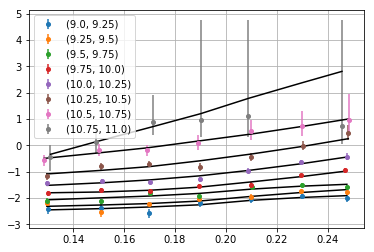

In [20]:
colors = [f'kC{i}' for i in range(9)]
for m0_m1, color in zip(list(fits)[3:], colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=True, colors=color, label=str(m0_m1))
plt.grid()
# plt.ylim(-3.5, 0.5)
plt.legend();

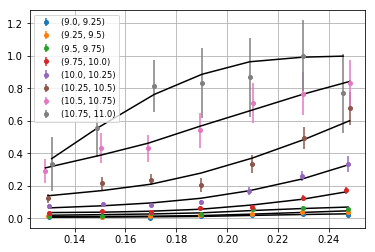

In [21]:
colors = [f'kC{i}' for i in range(9)]
for m0_m1, color in zip(list(fits)[3:], colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=False, colors=color, label=str(m0_m1))
plt.grid()
plt.legend(fontsize='small', loc='upper left')

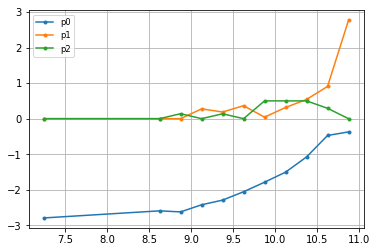

In [22]:
p0s = []
p1s = []
p2s = []
mags = []
for m0_m1, fit in fits.items():
    ps = fit.parvals
    m0, m1 = m0_m1
    mags.append((m0 + m1) / 2)
    p0s.append(ps[0])
    p1s.append(ps[1])
    p2s.append(ps[2])
plt.plot(mags, p0s, '.-', label='p0')
plt.plot(mags, p1s, '.-', label='p1')
plt.plot(mags, p2s, '.-', label='p2')
plt.legend(fontsize='small')
plt.grid()

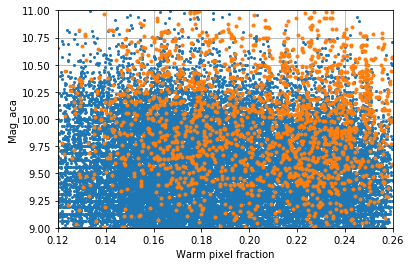

In [26]:
da = data_all
fz = 0.001
ok = (da['year'] > 2014.0) & ~da['fail'].astype(bool)
da14 = da[ok]
fuzz = np.random.uniform(-fz, fz, len(da14))
plt.plot(da14['warm_pix'] + fuzz, da14['mag'], '.C0', markersize=4)

ok = (da['year'] > 2014.0) & da['fail'].astype(bool)
da14 = da[ok]
fuzz = np.random.uniform(-fz, fz, len(da14))
plt.plot(da14['warm_pix'] + fuzz, da14['mag'], '.C1')
plt.xlim(0.12, 0.26)
plt.ylim(9.0, 11.0)
plt.xlabel('Warm pixel fraction')
plt.ylabel('Mag_aca')
plt.grid()